# **Space X  Falcon 9 First Stage Landing Prediction**


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

## Functions

In [2]:
def plot_confusion_matrix(y, y_predict, model):
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f'Confusion Matrix - {model}')
    ax.xaxis.set_ticklabels(['Failure', 'Success'])
    ax.yaxis.set_ticklabels(['Failure', 'Success'])
    
def plot_cm(test, predictions):
    #figure setup
    fig = plt.figure(figsize=(10,8))
    
    #titles for each plot
    titles = ["Logistic Regression", "SVM", "Decision Tree", "K-Nearest Neighbor"]
    
    for i, pred in enumerate(predictions):
        ax = fig.tight_layout(pad=2)
        ax = fig.add_subplot(2,2,i+1)
            
        #plot
        cm = confusion_matrix(test, pred)
        ax = sns.heatmap(cm, annot=True)
                
        #lines, labels, and limits
        ax.axhline(y=0, color='black', linewidth=6, alpha=.7)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.tick_params(labelsize=16)
        ax.tick_params(axis='y', pad=10, labelrotation=0)
        ax.set_title(titles[i], pad=10.0)
                
    #figure title & subtitle
    ax.text(0.02, 1.02, s=title, fontsize=28, weight='bold', alpha=.75, transform=fig.transFigure)
    ax.text(0.02, .98, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=0.01, y=-0.0,
            s=' ©NoahGampe' + ' '*90 + 'Source: SpaceX Wikipedia ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=fig.transFigure)   
    
    plt.show()

# Data Preparation

In [3]:
#dataset containing outcome results
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
#dataset containing ML features
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [5]:
#target variable
y = data['Class'].to_numpy()
y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f' X_test: {X_test.shape},  y_test: {y_test.shape}')

X_train: (72, 83), y_train: (72,)
 X_test: (18, 83),  y_test: (18,)


## Creating Pipeline

In [7]:
#creating pipelines
pipeline_LR  = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])
pipeline_SVM = Pipeline([('scaler', StandardScaler()), ('SVM', SVC())])
pipeline_DT  = Pipeline([('scaler', StandardScaler()), ('DT', DecisionTreeClassifier())])
pipeline_KNN = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])

pipelines = [pipeline_LR, pipeline_SVM, pipeline_DT, pipeline_KNN]

pipe_dict = {0: "LOGISTIC REGRESSION",
             1: "SUPPORT VECTOR MACHINE CLASSIFIER",
             2: "DECISION TREE CLASSIFIER",             
             3: "K-NEAREST NEIGHBOR CLASSIFIER"}

#parameters for gridsearch
parameters_lr = {'LR__C': [0.001, 0.01, 0.1, 1],
                 'LR__penalty': ['l2'],
                 'LR__solver': ['lbfgs', 'liblinear']}

parameters_svm = {'SVM__kernel': ('linear', 'rbf','poly','rbf', 'sigmoid'),
                  'SVM__C': np.logspace(-3, 3, 5),
                  'SVM__gamma': np.logspace(-3, 3, 5)}

parameters_dt = {'DT__criterion': ['gini', 'entropy'],
                 'DT__splitter': ['best', 'random'],
                 'DT__max_depth': [2*n for n in range(1,10)],
                 'DT__max_features': ['auto', 'sqrt'],
                 'DT__min_samples_leaf': [1, 2, 4],
                 'DT__min_samples_split': [2, 5, 10]}

parameters_knn = {'KNN__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'KNN__p': [1,2]}

parameters = [parameters_lr, parameters_svm, parameters_dt, parameters_knn]

In [8]:
reports = []
models = {}
predictions = []
train_scores = []
test_scores = []
labels = ['0 - Failed', '1 - Success']

for i, pipe in enumerate(pipelines):
    print('*'*53)
    print(f'{pipe_dict[i]}')
    pipe_cv = GridSearchCV(pipe, parameters[i], cv=10)
    pipe_cv.fit(X_train, y_train)
    pred = pipe_cv.predict(X_test)
    
    models[pipe.steps[1][0]] = pipe_cv
    predictions.append(pred)
    
    #print classification report    
    class_scores = precision_recall_fscore_support(y_test, predictions[-1], average='weighted', zero_division=0)
    reports.append(classification_report(y_test, predictions[-1], digits=3, zero_division=0, target_names=labels))
    print(reports[-1])
    
    train_scores.append(round(pipe_cv.best_score_*100,3))
    test_scores.append(round(pipe_cv.score(X_test, y_test)*100,3))    
    print(f'Train Score: {train_scores[-1]}')   
    print(f' Test Score: {test_scores[-1]}\n')

*****************************************************
LOGISTIC REGRESSION
              precision    recall  f1-score   support

  0 - Failed      1.000     0.500     0.667         6
 1 - Success      0.800     1.000     0.889        12

    accuracy                          0.833        18
   macro avg      0.900     0.750     0.778        18
weighted avg      0.867     0.833     0.815        18

Train Score: 84.643
 Test Score: 83.333

*****************************************************
SUPPORT VECTOR MACHINE CLASSIFIER
              precision    recall  f1-score   support

  0 - Failed      1.000     0.500     0.667         6
 1 - Success      0.800     1.000     0.889        12

    accuracy                          0.833        18
   macro avg      0.900     0.750     0.778        18
weighted avg      0.867     0.833     0.815        18

Train Score: 82.143
 Test Score: 83.333

*****************************************************
DECISION TREE CLASSIFIER
              precision

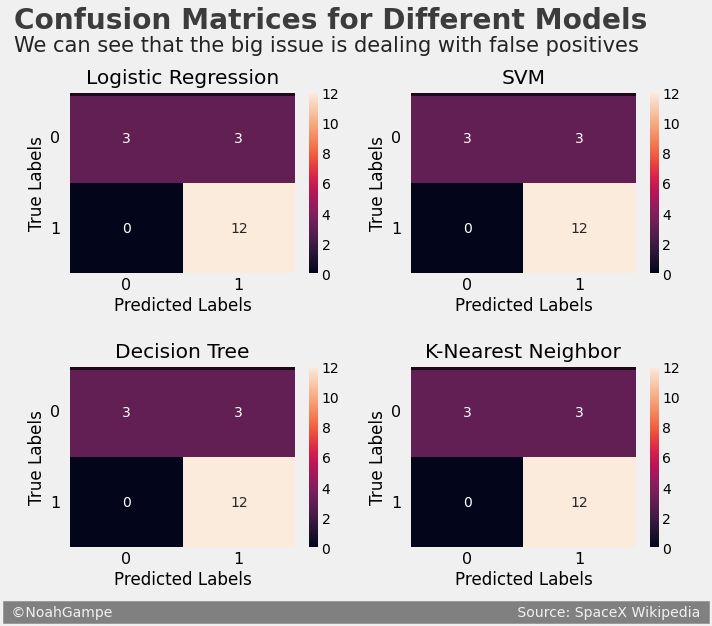

In [9]:
#confusion matrix
title = "Confusion Matrices for Different Models"
sub = "We can see that the big issue is dealing with false positives"
plot_cm(y_test, predictions)

Find the method performs best:


In [10]:
train_scores

[84.643, 82.143, 89.107, 84.821]

In [11]:
test_scores

[83.333, 83.333, 83.333, 83.333]

In [21]:
models['SVM'].best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM',
                 SVC(C=0.03162277660168379, gamma=0.001, kernel='linear'))])